## Exercise 1.4 Hotdog -- no hotdog
This is the first poster hand-in exercise for the course. Please see the associated PDF for instructions.

In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We always check that we are running on a GPU

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [3]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='../hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [4]:
size = 128
rotation_range = 20

# train_transform = transforms.Compose([transforms.Resize((size, size)), 
#                                     transforms.ToTensor(),
#                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
#                                     transforms.RandomRotation(rotation_range),

#                                     ])
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                    
                                    ])

train_transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),    
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

batch_size = 16
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)


Let's look at some images from our data 

In [5]:
# images, labels = next(iter(train_loader))
# plt.figure(figsize=(20,10))

# for i in range(21):
#     plt.subplot(5,7,i+1)
#     plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
#     plt.title(['hotdog', 'not hotdog'][labels[i].item()])
#     plt.axis('off')


Now create a model and train it!


In [6]:

init_type = init=nn.init.xavier_uniform_

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.convolutional1 = nn.Sequential(
                nn.Conv2d(3, 128, kernel_size=7, padding=3),
                nn.BatchNorm2d(128,eps=1e-04),
                nn.ReLU(inplace=True),
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128,eps=1e-04),
                nn.ReLU(inplace=True),
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128,eps=1e-04),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2),
        )

        self.convolutional2 = nn.Sequential(
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.BatchNorm2d(256,eps=1e-04),
                nn.ReLU(inplace=True),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.BatchNorm2d(256,eps=1e-04),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2),
        )
        
        self.convolutional3 = nn.Sequential(
                nn.Conv2d(256, 128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128,eps=1e-04),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2),
        )
        self.convolutional4 = nn.Sequential(
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128,eps=1e-04),
                nn.ReLU(inplace=True),
        )
        

        self.fully_connected = nn.Sequential(
                nn.Linear(16*16*128, 1024),
                nn.ReLU(),
                nn.Dropout(0.30),
                nn.Linear(1024, 512),
                nn.ReLU(),
                nn.Dropout(0.30),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, 64),
                nn.ReLU(),
                nn.Linear(64, 2),
                # nn.Softmax(dim=1)
                )
        
    def forward(self, x):
        x = self.convolutional1(x)
        x = self.convolutional2(x)
        x = self.convolutional3(x)
        x = self.convolutional4(x)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        
        return x
    
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

In [7]:
model = Network()
model.apply(init_weights)
model.to(device)
#Initialize the optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00004, weight_decay=0.1)

In [8]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    def loss_fun(output, target):
        return F.cross_entropy(output, target)
    out_dict = {
              'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    return out_dict



In [9]:
out_dict = train(model, optimizer, num_epochs=16)

  0%|          | 0/16 [00:00<?, ?epoch/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.658	 test: 0.580	 Accuracy train: 62.9%	 test: 70.0%


  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.580	 test: 0.612	 Accuracy train: 69.3%	 test: 70.2%


  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.543	 test: 0.602	 Accuracy train: 72.9%	 test: 67.5%


  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.521	 test: 0.511	 Accuracy train: 75.0%	 test: 75.8%


  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.500	 test: 0.544	 Accuracy train: 76.1%	 test: 72.6%


  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.491	 test: 0.607	 Accuracy train: 76.7%	 test: 68.2%


  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.482	 test: 0.536	 Accuracy train: 78.7%	 test: 74.9%


  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.478	 test: 0.571	 Accuracy train: 78.4%	 test: 74.4%


  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.477	 test: 0.645	 Accuracy train: 77.7%	 test: 67.8%


  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.476	 test: 0.477	 Accuracy train: 77.6%	 test: 77.6%


  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.461	 test: 0.503	 Accuracy train: 79.3%	 test: 77.1%


  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.456	 test: 0.516	 Accuracy train: 79.5%	 test: 78.1%


  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.480	 test: 0.619	 Accuracy train: 78.1%	 test: 73.2%


  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.479	 test: 0.559	 Accuracy train: 78.1%	 test: 73.4%


  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.470	 test: 0.496	 Accuracy train: 78.8%	 test: 76.5%


  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.450	 test: 0.499	 Accuracy train: 80.2%	 test: 75.9%


Text(0, 0.5, 'Accuracy')

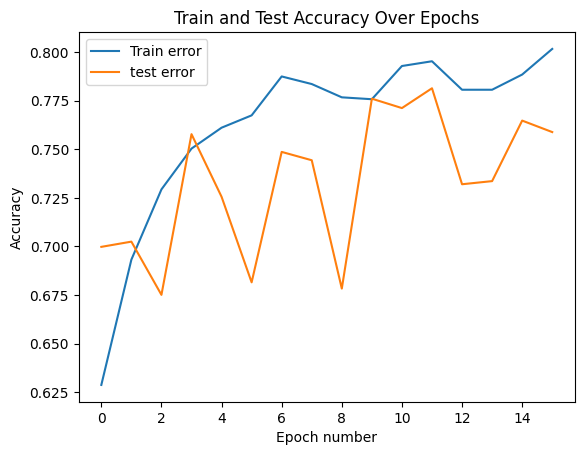

In [10]:
plt.plot(out_dict['train_acc'], label='Train Accuracy')
plt.plot(out_dict['test_acc'], label='Test Accuracy')
plt.title('Train and Test Accuracy Over Epochs')
plt.legend(('Train error','test error'))
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

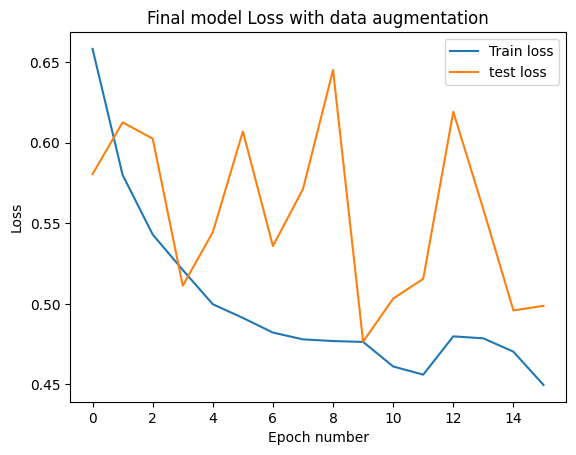

In [11]:
plt.plot(out_dict['train_loss'], label='Train Loss')
plt.plot(out_dict['test_loss'], label='Test Loss')
plt.title('Final model Loss with data augmentation')
plt.legend(('Train loss','test loss'))
plt.xlabel('Epoch number')
plt.ylabel('Loss')

In [12]:
print("train accuracy: ")
print(out_dict['train_acc'])
print("test accuracy: " )
print(out_dict['test_acc'])

train accuracy: 
[0.6287249633610161, 0.693209574987787, 0.7293600390815828, 0.7503663898387885, 0.761113825109917, 0.7674645823155838, 0.7874938935026868, 0.7835857352222765, 0.7767464582315584, 0.7757694186614558, 0.7928676111382511, 0.7953102100635075, 0.7806546165119688, 0.7806546165119688, 0.7884709330727895, 0.8016609672691744]
test accuracy: 
[0.6997851772287863, 0.7024704618689581, 0.6750805585392051, 0.7577873254564984, 0.7255639097744361, 0.6815252416756176, 0.748657357679914, 0.7443609022556391, 0.6783029001074113, 0.776047261009667, 0.7712137486573577, 0.7814178302900108, 0.7320085929108485, 0.7336197636949516, 0.7647690655209453, 0.7588614393125671]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


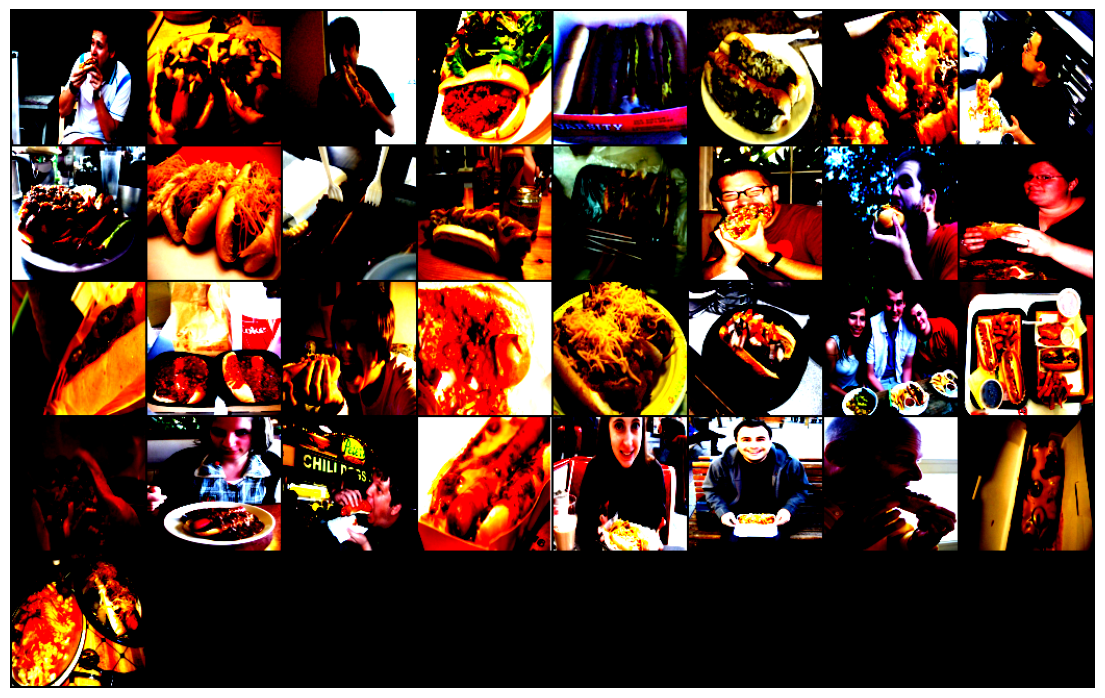

    TRUE        PREDICTED
-----------------------------
0,    hotdog      not hotdog  
1,    hotdog      not hotdog  
2,    hotdog      not hotdog  
3,    hotdog      not hotdog  
4,    hotdog      not hotdog  
5,    hotdog      not hotdog  
6,    hotdog      not hotdog  
7,    hotdog      not hotdog  
8,    hotdog      not hotdog  
9,    hotdog      not hotdog  
10,    hotdog      not hotdog  
11,    hotdog      not hotdog  
12,    hotdog      not hotdog  
13,    hotdog      not hotdog  
14,    hotdog      not hotdog  
15,    hotdog      not hotdog  
16,    hotdog      not hotdog  
17,    hotdog      not hotdog  
18,    hotdog      not hotdog  
19,    hotdog      not hotdog  
20,    hotdog      not hotdog  
21,    hotdog      not hotdog  
22,    hotdog      not hotdog  
23,    hotdog      not hotdog  
24,    hotdog      not hotdog  
25,    hotdog      not hotdog  
26,    hotdog      not hotdog  
27,    hotdog      not hotdog  
28,    hotdog      not hotdog  
29,    hotdog      not hot

In [14]:
from torchvision.utils import make_grid
import seaborn as sns

def show_image(img):
    img = img.detach().cpu()
    # img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(14, 14))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=256, shuffle=False)


        
model.to("cpu")
inputs, targets = next(iter(test_loader))
inputs, targets = inputs.to("cpu"), targets.to("cpu")

outputs = model(inputs)
_, predicted = torch.max(outputs.data, 1)

# Remove images that were predicted correctly
mask = predicted == targets
inputs = inputs[~mask]
predicted = predicted[~mask]
targets = targets[~mask]
show_image(make_grid(inputs))
plt.show()


print("    TRUE        PREDICTED")
print("-----------------------------")
for i, (target, pred) in enumerate(zip(targets, predicted)):
    print(f"{i}, {['hotdog', 'not hotdog'][target.item()]:^13} {['hotdog', 'not hotdog'][pred.item()]:^13}")
